# Plug-Flow Reactor (PFR)

Code is ported (almost) verbatim from cantera example file `pfr.py` (distributed with cantera):
```
"""
This example solves a plug-flow reactor problem of hydrogen-oxygen combustion.
The PFR is computed by two approaches: The simulation of a Lagrangian fluid
particle, and the simulation of a chain of reactors.
"""
```

In [1]:
import cantera as ct
import numpy as np

import matplotlib.pyplot as plt
%matplotlib notebook

## Input Parameters

In [2]:
T_0 = 1500.0  # inlet temperature [K]
pressure = ct.one_atm  # constant pressure [Pa]
composition_0 = 'H2:2, O2:1, AR:0.1'
length = 1.5e-7  # *approximate* PFR length [m]
u_0 = .006  # inflow velocity [m/s]
area = 1.e-4  # cross-sectional area [m**2]

# input file containing the reaction mechanism
reaction_mechanism = 'h2o2.xml'

# Resolution: The PFR will be simulated by 'n_steps' time steps or by a chain
# of 'n_steps' stirred reactors.
n_steps = 2000

## Method 1: Lagrangian Particle Simulation

A Lagrangian particle is considered which travels through the PFR. Its
state change is computed by upwind time stepping. The PFR result is produced
by transforming the temporal resolution into spatial locations.
The spatial discretization is therefore not provided a priori but is instead
a result of the transformation.

In [3]:
# import the gas model and set the initial conditions
gas1 = ct.Solution(reaction_mechanism)
gas1.TPX = T_0, pressure, composition_0
mass_flow_rate1 = u_0 * gas1.density * area

# create a new reactor
r1 = ct.IdealGasConstPressureReactor(gas1)
# create a reactor network for performing time integration
sim1 = ct.ReactorNet([r1])

# approximate a time step to achieve a similar resolution as in the next method
t_total = length / u_0
dt = t_total / n_steps
# define time, space, and other information vectors
t1 = (np.arange(n_steps) + 1) * dt
z1 = np.zeros_like(t1)
u1 = np.zeros_like(t1)
states1 = ct.SolutionArray(r1.thermo)
for n1, t_i in enumerate(t1):
    # perform time integration
    sim1.advance(t_i)
    # compute velocity and transform into space
    u1[n1] = mass_flow_rate1 / area / r1.thermo.density
    z1[n1] = z1[n1 - 1] + u1[n1] * dt
    states1.append(r1.thermo.state)

## Method 2: Chain of Reactors

The plug flow reactor is represented by a linear chain of zero-dimensional
reactors. The gas at the inlet to the first one has the specified inlet
composition, and for all others the inlet composition is fixed at the
composition of the reactor immediately upstream. Since in a PFR model there
is no diffusion, the upstream reactors are not affected by any downstream
reactors, and therefore the problem may be solved by simply marching from
the first to last reactor, integrating each one to steady state.
(This approach is anologous to the one presented in 'surf_pfr.py', which
additionally includes surface chemistry)

In [4]:
# import the gas model and set the initial conditions
gas2 = ct.Solution(reaction_mechanism)
gas2.TPX = T_0, pressure, composition_0
mass_flow_rate2 = u_0 * gas2.density * area
dz = length / n_steps
r_vol = area * dz

# create a new reactor
r2 = ct.IdealGasReactor(gas2)
r2.volume = r_vol

# create a reservoir to represent the reactor immediately upstream. Note
# that the gas object is set already to the state of the upstream reactor
upstream = ct.Reservoir(gas2, name='upstream')

# create a reservoir for the reactor to exhaust into. The composition of
# this reservoir is irrelevant.
downstream = ct.Reservoir(gas2, name='downstream')

# The mass flow rate into the reactor will be fixed by using a
# MassFlowController object.
m = ct.MassFlowController(upstream, r2, mdot=mass_flow_rate2)

# We need an outlet to the downstream reservoir. This will determine the
# pressure in the reactor. The value of K will only affect the transient
# pressure difference.
v = ct.PressureController(r2, downstream, master=m, K=1e-5)

sim2 = ct.ReactorNet([r2])

# define time, space, and other information vectors
z2 = (np.arange(n_steps) + 1) * dz
t_r2 = np.zeros_like(z2)  # residence time in each reactor
u2 = np.zeros_like(z2)
t2 = np.zeros_like(z2)
states2 = ct.SolutionArray(r2.thermo)
# iterate through the PFR cells
for n in range(n_steps):
    # Set the state of the reservoir to match that of the previous reactor
    gas2.TDY = r2.thermo.TDY
    upstream.syncState()
    # integrate the reactor forward in time until steady state is reached
    sim2.reinitialize()
    sim2.advance_to_steady_state()
    # compute velocity and transform into time
    u2[n] = mass_flow_rate2 / area / r2.thermo.density
    t_r2[n] = r2.mass / mass_flow_rate2  # residence time in this reactor
    t2[n] = np.sum(t_r2)
    # write output data
    states2.append(r2.thermo.state)

## Compare Results in matplotlib

<IPython.core.display.Javascript object>


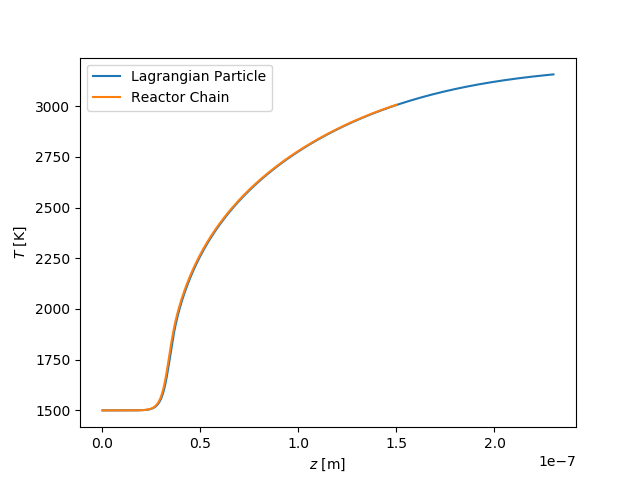

In [5]:
plt.figure()
plt.plot(z1, states1.T, label='Lagrangian Particle')
plt.plot(z2, states2.T, label='Reactor Chain')
plt.xlabel('$z$ [m]')
plt.ylabel('$T$ [K]')
_ = plt.legend(loc=0)
#plt.show()
#plt.savefig('pfr_T_z.png')

<IPython.core.display.Javascript object>


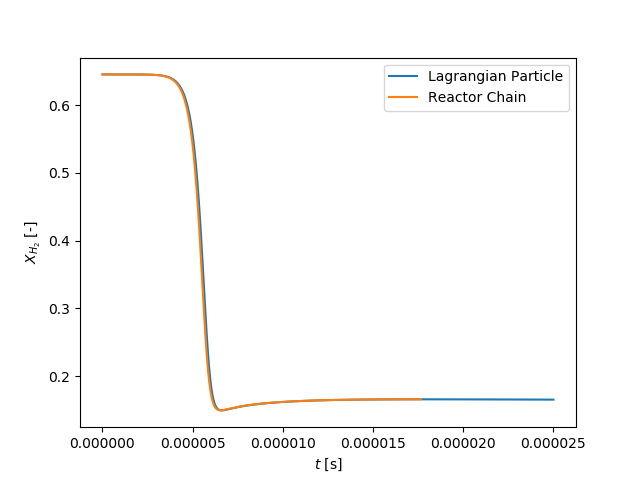

In [6]:
plt.figure()
plt.plot(t1, states1.X[:, gas1.species_index('H2')], label='Lagrangian Particle')
plt.plot(t2, states2.X[:, gas2.species_index('H2')], label='Reactor Chain')
plt.xlabel('$t$ [s]')
plt.ylabel('$X_{H_2}$ [-]')
_ = plt.legend(loc=0)
#plt.show()
#plt.savefig('pfr_XH2_t.png')